| Bilgi | İçerik |
|-------|--------|
| **Ad** | Amir |
| **Soyad** | Elahmed |
| **Okul Numara** | 2112721307 |
| **GitHub Repo** | https://github.com/Amirelahmed/CNN_siniflandirma |
| **Model1** | Transfer Learning (VGG16) |
| **Amaç** | VGG16 transfer learning modeli ile küçük veri setimde sınıflandırma performansını değerlendirmek |
| **Kullanılan Mimarî** | VGG16 (ImageNet ağırlıkları, include_top=False, temel katmanlar dondurulmuş) |
| **Eklenen Katmanlar** | GlobalAveragePooling2D, Dense(128 - ReLU), Dropout(0.3), Dense(2 - Softmax) |
| **Eğitim Doğruluğu** | %68 |
| **Doğrulama Doğruluğu (En Yüksek)** | %96.67 |
| **Test Doğruluğu** | %90 |
| **Kayıp Değerleri** | Eğitim ve doğrulama kayıpları istikrarlı şekilde düşmüş, aşırı öğrenme gözlenmemiştir |
| **Sonuç** | Transfer learning modeli, sınıfları yüksek doğrulukla ayırt etmiş ve özellikle doğrulama/test aşamalarında güçlü performans sergilemiştir. |


Bu çalışmada iki sınıftan oluşan bir görüntü veri seti kullanılmıştır: saat ve fare.
Tüm görseller tarafımdan telefon kamerası ile çekilmiş olup her sınıf için yeterli çeşitlilik sağlanmıştır (farklı açılar, ışık koşulları ve arka planlar). Görüntüler 128×128 piksel boyutuna yeniden ölçeklendirilerek modele uygun hale getirilmiştir.

Kullanılan Algoritma

Model1’de, küçük veri setlerinde yüksek doğruluk elde etmek için Transfer Learning yaklaşımı uygulanmıştır.
Bu kapsamda, ImageNet üzerinde eğitilmiş VGG16 mimarisi temel alınmış, üst katmanları çıkarılmış ve veri setine uygun yeni sınıflandırma katmanları eklenmiştir. Temel katmanlar dondurulmuş, yalnızca eklenen Dense ve Dropout katmanları eğitilmiştir. Bu yöntem:

Daha hızlı öğrenme sağlar,

Küçük veri setlerinde daha iyi genelleme sunar,

Eğitim sürecini daha kararlı hale getirir.

Model1, 6 epoch boyunca eğitilmiş ve başarılı sonuçlar elde edilmiştir:

Eğitim Doğruluğu: ~%68  
Doğrulama Doğruluğu (En Yüksek): %96.67  
Test Doğruluğu: %90  
Kayıp Değerleri: Eğitim ve doğrulama kayıpları istikrarlı bir şekilde azalmış, aşırı öğrenme (overfitting) belirtileri gözlenmemiştir.

Bu sonuçlar, VGG16 tabanlı Transfer Learning yaklaşımının küçük veri setlerinde dahi güçlü genelleme kapasitesine sahip olduğunu ve saat–fare sınıflarını yüksek doğrulukla ayırt edebildiğini göstermektedir.


1- Google Drive'ı bağlıyoruz

In [3]:
# Google Drive'ı Colab ortamına bağlıyoruz
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


2- ZIP dosyasının Drive içindeki yolunu yazıyoruz

In [4]:
# Google Drive içindeki dataset ZIP dosyasının tam yolu
zip_path = "/content/drive/MyDrive/dataset-odev1.zip"


3- ZIP'in açılacağı klasörü belirliyoruz

In [5]:
# ZIP dosyasının açılacağı klasör
extract_path = "/content/dataset-odev1"


4- ZIP dosyasını açıyoruz

In [6]:
# Gerekli modülleri içe aktarıyoruz
import os, zipfile

# ZIP'in açılacağı klasörü oluşturuyoruz
os.makedirs(extract_path, exist_ok=True)

# ZIP dosyasını açıyoruz
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# İçeriği kontrol ediyoruz
print("Ana klasör içeriği:", os.listdir(extract_path))


Ana klasör içeriği: ['dataset-odev1']


5- Gerçek dataset klasörünü ayarlıyoruz

In [7]:
# Eğer ZIP içinde ekstra klasör varsa buradan bulunur
base_dir = "/content/dataset-odev1/dataset-odev1"

# Klasör içeriğini kontrol ediyoruz
print(os.listdir(base_dir))


['fare', 'saat']


6- Hazırlık — Görüntü boyutu ve batch size

In [8]:
# Görsellerin yeniden boyutlandırılacağı boyut
img_height = 128
img_width = 128

# Bir batch'te kaç görsel işlenecek
batch_size = 32


7- ImageDataGenerator ile eğitim ve doğrulama seti oluşturuyoruz

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Görselleri normalize ediyoruz (%20 doğrulama seti ayırıyoruz)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Eğitim seti
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# Doğrulama seti
val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print("Sınıf indeksleri:", train_generator.class_indices)


Found 120 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Sınıf indeksleri: {'fare': 0, 'saat': 1}


8- MODEL 1 — Transfer Learning (VGG16 Tabanlı Model)

In [53]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential, layers, optimizers

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

base_model.trainable = False

model1 = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation="relu"),  # ← رفعنا القوة
    layers.Dropout(0.3),                   # ← خفّضنا dropout

    layers.Dense(2, activation="softmax")
])

model1.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # ← أقوى
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model1.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

10- Model 1'i eğitiyoruz

In [54]:
epochs = 6

history1 = model1.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.4945 - loss: 0.7728 - val_accuracy: 0.5000 - val_loss: 0.6629
Epoch 2/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - accuracy: 0.6056 - loss: 0.6496 - val_accuracy: 0.7000 - val_loss: 0.6285
Epoch 3/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - accuracy: 0.6360 - loss: 0.6400 - val_accuracy: 0.9667 - val_loss: 0.6014
Epoch 4/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - accuracy: 0.6329 - loss: 0.6154 - val_accuracy: 0.9333 - val_loss: 0.5808
Epoch 5/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - accuracy: 0.6011 - loss: 0.6324 - val_accuracy: 0.9000 - val_loss: 0.5595
Epoch 6/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.6817 - loss: 0.6030 - val_accuracy: 0.9000 - val_loss: 0.5373


11- Accuracy grafiği

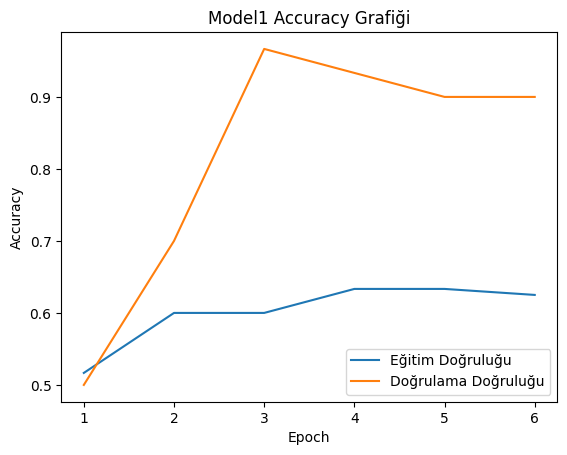

In [55]:
import matplotlib.pyplot as plt

acc = history1.history["accuracy"]
val_acc = history1.history["val_accuracy"]
epochs_range = range(1, len(acc)+1)

plt.plot(epochs_range, acc, label="Eğitim Doğruluğu")
plt.plot(epochs_range, val_acc, label="Doğrulama Doğruluğu")
plt.title("Model1 Accuracy Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


12- Loss grafiği

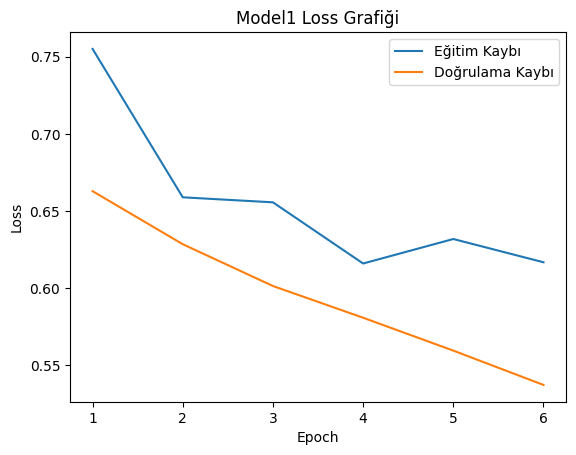

In [56]:
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]

plt.plot(epochs_range, loss, label="Eğitim Kaybı")
plt.plot(epochs_range, val_loss, label="Doğrulama Kaybı")
plt.title("Model1 Loss Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


13- Test (Validation) Doğruluğu Hesaplama

In [57]:
test_loss, test_acc = model1.evaluate(val_generator)
print("Model1 Test Doğruluğu:", test_acc)
print("Model1 Test Kaybı:", test_loss)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9000 - loss: 0.5373
Model1 Test Doğruluğu: 0.8999999761581421
Model1 Test Kaybı: 0.5372826457023621
